In [2]:
import swiftsimio as sw
from matplotlib import pyplot as plt
import numpy as np
import unyt
import time
import scipy
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from LoadSimulation import LoadSimulation

In [3]:
hydro = LoadSimulation('/data2/quinten/data/hydro_fiducial/SOAP-HBT/halo_properties_0077.hdf5', 2e11, 100)
dmo = LoadSimulation('/data2/quinten/data/dmo_fiducial/SOAP-HBT/halo_properties_0077.hdf5', 2e11, 100)
hydro_agn = LoadSimulation('/data2/quinten/data/hydro_strongest_agn/SOAP-HBT/halo_properties_0077.hdf5', 2e11, 100)

/net/hydra/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (1 at a=1.0) for all arguments.
  warnings.warn(
/net/hydra/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/net/hydra/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:430: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/net/hydra/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (1 at a=1.0) for al

In [9]:
def BinVelocity(x, v):
    bins = np.arange(np.max(x))
    v_std = binned_statistic(x, v, statistic='std', bins=bins)[0]
    v_median = binned_statistic(x, np.abs(v), statistic='median', bins=bins)[0]
    v_p16 = binned_statistic(x, np.abs(v), statistic=lambda x: np.percentile(x, 16), bins=bins)[0]
    v_p84 = binned_statistic(x, np.abs(v), statistic=lambda x: np.percentile(x, 84), bins=bins)[0]
    return bins[:-1], v_std, v_median, v_p16, v_p84

In [18]:
def BinVelocityNonnanLog(x, v):
    x_v_list = BinVelocity(x, v)
    nonnan = ~np.isnan(x_v_list[1])
    return np.log10(np.array(x_v_list)[:, nonnan])

In [70]:
def f_exp(x, a, b, c, d):
    return a*np.exp(b*x-d)+c

def f_powerlaw(x, a, p, c):
    return a*x**p+c

def f_c_to_lin_lin(x, x0, d, m, c):
    y = []
    for i in x:
        if i < x0:
            y.append(c)
        elif i > x0 + d:
            y.append(m*(i-x0)-m*d/2+c)
        else:
            y.append(.5*m*(i-x0)*(i-x0)/d + c)
    return np.array(y)

def f_c_to_lin_exp(x, t, m, c):
    return (m*x)*np.exp(-t/x)+c

In [38]:
def PlotFit(ax1, ax2, f, x, v, xx, fstr=None, p0=None):
    fit = curve_fit(f, x, v, p0=p0)
    if fstr != None:
        fstr = fstr.format(*fit[0])
    ax1.scatter(x,v, color='r', s=5)
    ax1.plot(xx, f(xx, *fit[0]), color='black')
    ax2.scatter(10**x,10**v, color='r', s=5)
    ax2.plot(10**xx, 10**f(xx, *fit[0]), color='black')
    ax1.text(0, 2.6, fstr)


In [74]:
x, _, v, _, _ = BinVelocityNonnanLog(dmo.galaxy_density, dmo.vpx)

/var/tmp/zegveld/ipykernel_1172188/3013582581.py:19: RuntimeWarning: divide by zero encountered in divide
  return (m*x)*np.exp(-t/x)+c


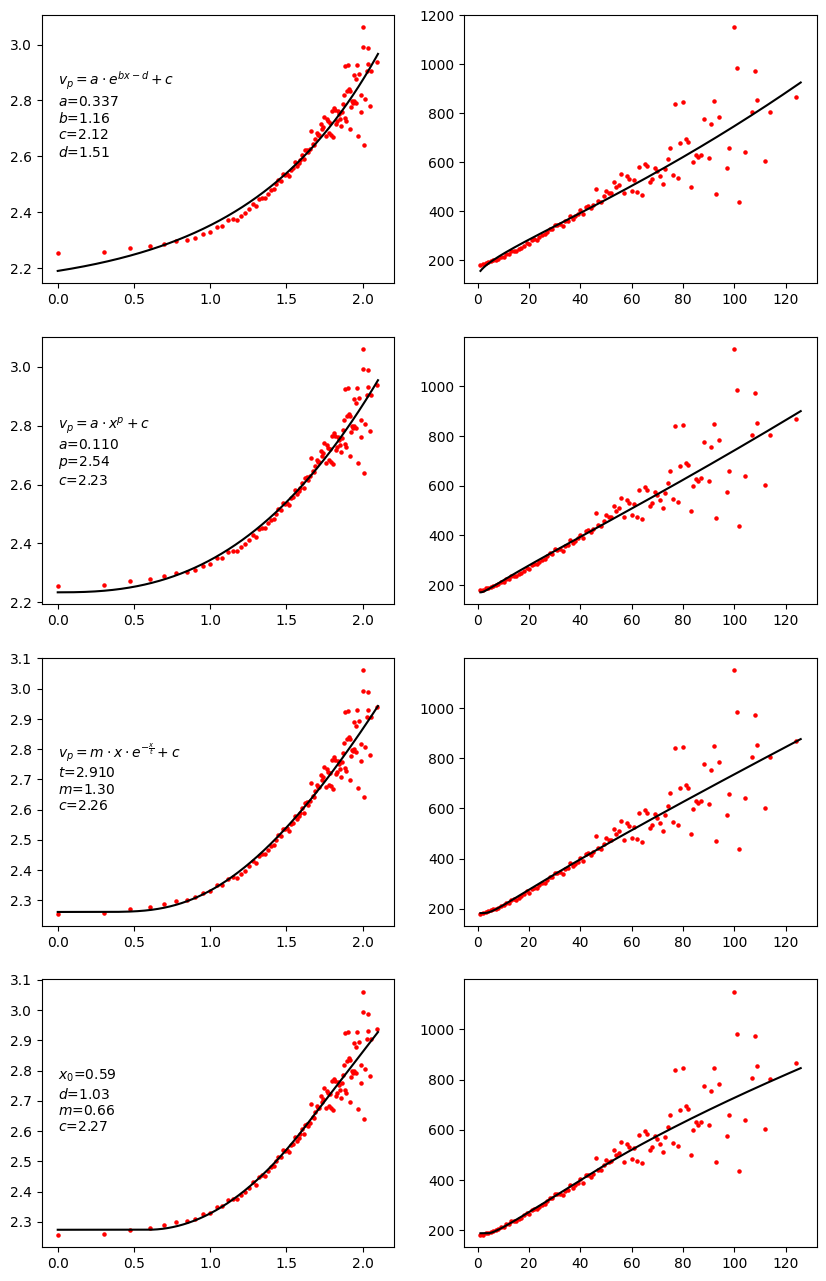

In [76]:
fig, ax = plt.subplots(4, 2, figsize=[10,16])

p1 = [.8, 1, 2.3]

xx = np.linspace(0, 2.1, 1000)
PlotFit(*ax[0], f_exp, x, v, xx, fstr='$v_p=a\\cdot e^{{bx-d}}+c$\n$a$={:.3f}\n$b$={:.2f}\n$c$={:.2f}\n$d$={:.2f}')
PlotFit(*ax[1], f_powerlaw, x, v, xx, fstr='$v_p=a\\cdot x^{{p}}+c$\n$a$={:.3f}\n$p$={:.2f}\n$c$={:.2f}')
PlotFit(*ax[2], f_c_to_lin_exp, x, v, xx, fstr='$v_p=m\\cdot x\\cdot e^{{-\\frac{{x}}{{t}}}}+c$\n$t$={:.3f}\n$m$={:.2f}\n$c$={:.2f}')
PlotFit(*ax[3], f_c_to_lin_lin, x, v, xx, fstr='$x_0$={:.2f}\n$d$={:.2f}\n$m$={:.2f}\n$c$={:.2f}')

In [ ]:
x_hydro, _, v_hydro, _, _ = BinVelocityNonnanLog(hydro.galaxy_density, hydro.vpx)
x_agn, _, v_agn, _, _ = BinVelocityNonnanLog(hydro.galaxy_density, hydro.vpx)
x_dmo, _, v_dmo, _, _ = BinVelocityNonnanLog(hydro.galaxy_density, hydro.vpx)